In [17]:
import torch
from torch.optim import Adam
import os
import numpy as np
import numpy.linalg as lg
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
results = []

# for file in os.listdir("./"):
#     if file == "baseline_results.npy":
#         baseline = np.load(file)


# for file in os.listdir("./"):
#     if file.endswith(".npy") and file.startswith("f="):
#         data = np.load(file)
#         results.append(data)
# result_matrix = np.concatenate(results, axis=1)



for file in os.listdir("./"):
    if file == "filtered_baseline.npy":
        baseline = np.load(file)
    elif file.startswith("filtered_results"):
        result_matrix = np.load(file)



# if index == 4:
#     result_matrix = np.mod(result_matrix + np.pi, 2*np.pi) - np.pi
# print(result_matrix.shape)
# print(baseline.shape)

In [19]:
baseline_x = baseline[:, 0]
baseline_y = baseline[:, 1]
baseline_v = baseline[:, 2]
baseline_w = baseline[:, 3]
baseline_phi = baseline[:, 4]

result_x = (result_matrix[:, 0::5] - baseline_x[:, None]).T
result_y = (result_matrix[:, 1::5] - baseline_y[:, None]).T
result_v = (result_matrix[:, 2::5] - baseline_v[:, None]).T
result_w = (result_matrix[:, 3::5] - baseline_w[:, None]).T
result_phi = (result_matrix[:, 4::5] - baseline_phi[:, None]).T
result_phi = np.mod(result_phi + 3*np.pi, 2*np.pi) - np.pi

In [20]:

U_x_, S_x, Vh_x = lg.svd(result_x, full_matrices=False)
U_y_, S_y, Vh_y = lg.svd(result_y, full_matrices=False)

losses_xy = []
for base_dim in range(1, 31):
    U_x = U_x_[:, :base_dim]
    U_y = U_y_[:, :base_dim]
    predicted_x = U_x @ U_x.T @ result_x
    predicted_y = U_y @ U_y.T @ result_y
    loss = np.square(result_x - predicted_x) + np.square(result_y - predicted_y)
    loss = np.mean(np.mean(loss))
    losses_xy.append(loss)
    # print(loss)



base_dim = 5

U_x, S_x, Vh_x = lg.svd(result_x, full_matrices=False)
U_y, S_y, Vh_y = lg.svd(result_y, full_matrices=False)
U_x = U_x[:, :base_dim]
U_y = U_y[:, :base_dim]

U_v, S_v, Vh_v = lg.svd(result_v, full_matrices=False)
U_w, S_w, Vh_w = lg.svd(result_w, full_matrices=False)
U_phi, S_phi, Vh_phi = lg.svd(result_phi, full_matrices=False)
U_v = U_v[:, :base_dim]
U_w = U_w[:, :base_dim]
U_phi = U_phi[:, :base_dim]

In [21]:
P_x = torch.tensor(U_x, requires_grad=True, dtype=torch.float32, device="cuda")
U_x = torch.tensor(U_x.T, requires_grad=True, dtype=torch.float32, device="cuda")
P_y = torch.tensor(U_y, requires_grad=True, dtype=torch.float32, device="cuda")
U_y = torch.tensor(U_y.T, requires_grad=True, dtype=torch.float32, device="cuda")

# optimiser = Adam((P_x, U_x, P_y, U_y), lr=0.001)


P_v = torch.tensor(U_v, requires_grad=True, dtype=torch.float32, device="cuda")
U_v = torch.tensor(U_v.T, requires_grad=True, dtype=torch.float32, device="cuda")
P_w = torch.tensor(U_w, requires_grad=True, dtype=torch.float32, device="cuda")
U_w = torch.tensor(U_w.T, requires_grad=True, dtype=torch.float32, device="cuda")
P_phi = torch.tensor(U_phi, requires_grad=True, dtype=torch.float32, device="cuda")
U_phi = torch.tensor(U_phi.T, requires_grad=True, dtype=torch.float32, device="cuda")

optimiser = Adam((P_v, U_v, P_w, U_w, P_phi, U_phi), lr=0.0005)

baseline_x = torch.tensor(baseline_x, dtype=torch.float32, device="cuda")
baseline_y = torch.tensor(baseline_y, dtype=torch.float32, device="cuda")
baseline_v = torch.tensor(baseline_v, dtype=torch.float32, device="cuda")
baseline_w = torch.tensor(baseline_w, dtype=torch.float32, device="cuda")
baseline_phi = torch.tensor(baseline_phi, dtype=torch.float32, device="cuda")

result_v_ = result_v.copy()
result_w_ = result_w.copy()
result_phi_ = result_phi.copy()

result_x = torch.tensor(result_x, dtype=torch.float32, device="cuda")
result_y = torch.tensor(result_y, dtype=torch.float32, device="cuda")
result_v = torch.tensor(result_v, dtype=torch.float32, device="cuda")
result_w = torch.tensor(result_w, dtype=torch.float32, device="cuda")
result_phi = torch.tensor(result_phi, dtype=torch.float32, device="cuda")

In [22]:
# predicted_v = result_v + baseline_v
# predicted_w = result_w + baseline_w
# predicted_phi = result_phi + baseline_phi

# predicted_w = torch.where(torch.abs(predicted_w) < 1e-8, 1e-8, predicted_w)
# predicted_x = predicted_v / predicted_w * (torch.sin(predicted_phi + predicted_w*4) - torch.sin(predicted_phi))
# predicted_y = predicted_v / predicted_w * (torch.cos(predicted_phi) - torch.cos(predicted_phi + predicted_w*4))

# loss = torch.square(result_x + baseline_x - predicted_x) + torch.square(result_y + baseline_y - predicted_y)
# loss = torch.mean(torch.mean(loss))
# print(loss.item())

# loss = torch.square(result_x) + torch.square(result_y)
# loss = torch.mean(torch.mean(loss))
# print(loss.item())
# loss = torch.square(result_x) + torch.square(result_y)
# loss = 1 - torch.exp(-loss)
# loss = torch.mean(torch.mean(loss))
# print(loss.item())

In [23]:
predicted_x = P_x @ U_x @ result_x
predicted_y = P_y @ U_y @ result_y

losses_x = torch.square(predicted_x - result_x) + torch.square(predicted_y - result_y)
large = torch.where(losses_x > 3, 1, 0)
print(large.size())
large = torch.sum(large, dim=0)
# print(large.size())
large_x = torch.where(large > 0, 1, 0)
print(large_x.size())
print(torch.sum(large_x))
print(torch.mean(torch.mean(losses_x)).item())


torch.Size([30, 398])
torch.Size([398])
tensor(1, device='cuda:0')
0.24223506450653076


In [24]:

epochs = 1000

U_v_, S_v, Vh_v = lg.svd(result_v_, full_matrices=False)
U_w_, S_w, Vh_w = lg.svd(result_w_, full_matrices=False)
U_phi_, S_phi, Vh_phi = lg.svd(result_phi_, full_matrices=False)

losses_vwphi = []


for base_dim in range(1, 31):
    U_v = U_v_[:, :base_dim]
    U_w = U_w_[:, :base_dim]
    U_phi = U_phi_[:, :base_dim]

    P_v = torch.tensor(U_v, requires_grad=True, dtype=torch.float32, device="cuda")
    U_v = torch.tensor(U_v.T, requires_grad=True, dtype=torch.float32, device="cuda")
    P_w = torch.tensor(U_w, requires_grad=True, dtype=torch.float32, device="cuda")
    U_w = torch.tensor(U_w.T, requires_grad=True, dtype=torch.float32, device="cuda")
    P_phi = torch.tensor(U_phi, requires_grad=True, dtype=torch.float32, device="cuda")
    U_phi = torch.tensor(U_phi.T, requires_grad=True, dtype=torch.float32, device="cuda")

    optimiser = Adam((P_v, U_v, P_w, U_w, P_phi, U_phi), lr=0.0005)

    for epoch in range(epochs):
        optimiser.zero_grad()
        predicted_v = P_v @ U_v @ result_v + baseline_v
        predicted_w = P_w @ U_w @ result_w + baseline_w
        predicted_phi = P_phi @ U_phi @ result_phi + baseline_phi

        predicted_w = torch.where(torch.abs(predicted_w) < 1e-8, 1e-8, predicted_w)
        predicted_x = predicted_v / predicted_w * (torch.sin(predicted_phi + predicted_w*4) - torch.sin(predicted_phi))
        predicted_y = predicted_v / predicted_w * (torch.cos(predicted_phi) - torch.cos(predicted_phi + predicted_w*4))

        loss = torch.square(result_x - predicted_x + baseline_x) + torch.square(result_y - predicted_y + baseline_y)
        # loss = 1 - torch.exp(-loss)
        loss = torch.mean(torch.mean(loss))
        # if epoch % 10 == 0:
        #     print(loss.size())
        #     print(loss.item())

        loss.backward()
        optimiser.step()

    losses_vwphi.append(loss.item())

# # print(losses_vwphi)

# plt.plot(np.arange(len(losses_vwphi)), np.array(losses_vwphi), label="trajectory bases")
# plt.show()


epochs = 2000

# for epoch in range(epochs):
#     optimiser.zero_grad()
#     predicted_x = P_x @ U_x @ result_x
#     predicted_y = P_y @ U_y @ result_y
#     loss = torch.square(result_x - predicted_x) + torch.square(result_y - predicted_y)
#     # loss = 1 - torch.exp(-loss)
#     loss = torch.mean(torch.mean(loss))
#     loss.backward()
#     optimiser.step()
#     if (epoch + 1) % 10 == 0:
#         print("loss:", loss.item())


# for epoch in range(100):
#     optimiser.zero_grad()
#     predicted_v = P_v @ U_v @ result_v + baseline_v
#     predicted_w = P_w @ U_w @ result_w + baseline_w
#     predicted_phi = P_phi @ U_phi @ result_phi + baseline_phi
#     predicted_x = predicted_v / predicted_w * (torch.sin(predicted_phi + predicted_w*4) - torch.sin(predicted_phi))
#     predicted_y = predicted_v / predicted_w * (torch.cos(predicted_phi) - torch.cos(predicted_phi + predicted_w*4))

#     losses = torch.square(result_x - predicted_x + baseline_x) + torch.square(result_y - predicted_y + baseline_y)
#     loss = torch.mean(torch.mean(losses))
#     loss.backward()
#     optimiser.step()
#     if (epoch) % 10 == 0:
#         print("loss:", loss.item())
#     if torch.isnan(loss):
#         print("NAN")
#         break





# for epoch in range(epochs):
#     optimiser.zero_grad()
#     predicted_v = P_v @ U_v @ result_v + baseline_v
#     # predicted_v = result_v + baseline_v

#     predicted_w = P_w @ U_w @ result_w + baseline_w
#     # predicted_w = baseline_w + result_w
#     predicted_phi = P_phi @ U_phi @ result_phi + baseline_phi
#     # predicted_phi = result_phi + baseline_phi

#     predicted_w = torch.where(torch.abs(predicted_w) < 1e-8, 1e-8, predicted_w)

#     predicted_x = predicted_v / predicted_w * (torch.sin(predicted_phi + predicted_w*4) - torch.sin(predicted_phi))
#     predicted_y = predicted_v / predicted_w * (torch.cos(predicted_phi) - torch.cos(predicted_phi + predicted_w*4))

#     losses = torch.square(result_x - predicted_x + baseline_x) + torch.square(result_y - predicted_y + baseline_y)
#     # loss = 1 - torch.exp(-loss)
#     loss = torch.mean(torch.mean(losses))
#     if torch.isnan(loss):
#         print("epoch:", epoch + 1)
#         print("NAN")
#         break
#     loss.backward()
#     optimiser.step()
#     if (epoch + 1) % 10 == 0:
#         print("loss:", loss.item())



# with torch.no_grad():
#     predicted_v = P_v @ U_v @ result_v + baseline_v
#     # predicted_v = result_v + baseline_v
#     predicted_w = P_w @ U_w @ result_w + baseline_w
#     predicted_phi = P_phi @ U_phi @ result_phi + baseline_phi

#     predicted_w = torch.where(torch.abs(predicted_w) < 1e-8, 1e-8, predicted_w)

#     predicted_x = predicted_v / predicted_w * (torch.sin(predicted_phi + predicted_w*4) - torch.sin(predicted_phi))
#     predicted_y = predicted_v / predicted_w * (torch.cos(predicted_phi) - torch.cos(predicted_phi + predicted_w*4))
#     loss = torch.square(result_x - predicted_x + baseline_x) + torch.square(result_y - predicted_y + baseline_y)
#     # loss = 1 - torch.exp(-loss)
#     loss = torch.mean(torch.mean(loss))
#     print("square loss", loss.item())

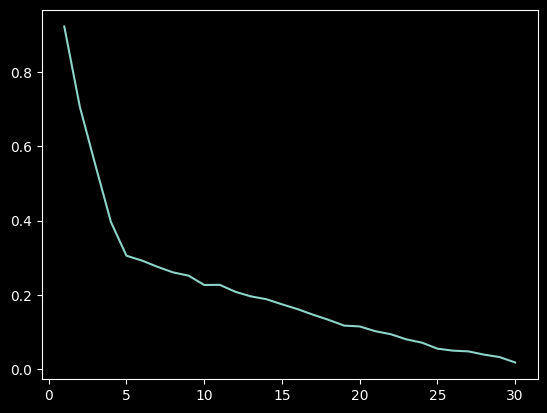

In [35]:
plt.plot(np.arange(len(losses_vwphi))+1, losses_vwphi)
plt.show()

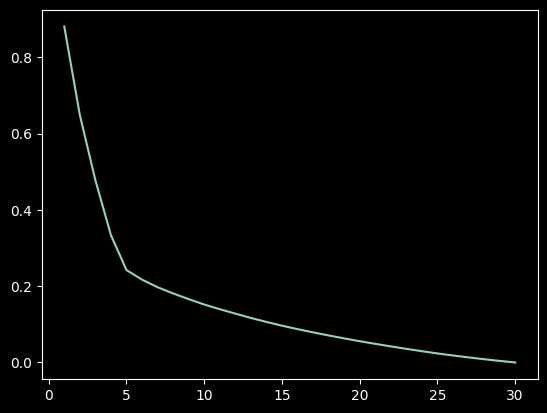

In [36]:
plt.plot(np.arange(len(losses_xy))+1, losses_xy)
plt.show()

In [37]:
elbow_data = np.vstack((losses_xy, losses_vwphi))

In [38]:
np.save("elbow_data_filtered.npy", elbow_data)

In [26]:
# large = torch.where(losses > 4, 1, 0)
# print(large.size())
# large = torch.sum(large, dim=0)
# # print(large.size())
# large = torch.where(large > 0, 1, 0)
# print(large.size())
# print(torch.sum(large).item())

# print(torch.sum(large_x).item())
# both_large = torch.where(large_x + large > 0, 1, 0)
# print(torch.sum(both_large).item())

In [27]:
# xy = []
# for i, j in enumerate(both_large):
#     if j:
#         continue
    
#     x, y = baseline[i, :2]
#     xy.append([x, y])

# xy = np.array(xy)

# plt.scatter(xy.T[0], xy.T[1])
# plt.show()



In [28]:
# losses_x_numpy = losses_x.detach().cpu().numpy()

# # print(losses_x_numpy.shape)
# # plt.hist(np.mean(losses_x_numpy, axis=0))

# losses_x_numpy = np.sqrt(losses_x_numpy)
# # plt.hist(np.where(losses_x_numpy > 1, 1, losses_x_numpy).reshape(-1), bins=30)
# plt.hist(losses_x_numpy.reshape(-1), bins=30)
# plt.show()

In [29]:
# losses_numpy = losses.detach().cpu().numpy()

# # print(losses_x_numpy.shape)
# # plt.hist(np.mean(losses_x_numpy, axis=0))

# losses_numpy = np.sqrt(losses_numpy)
# # plt.hist(np.where(losses_x_numpy > 1, 1, losses_x_numpy).reshape(-1), bins=30)
# plt.hist(losses_numpy.reshape(-1), bins=30)
# plt.show()

In [30]:
# filtered_baseline = []
# filtered_results = []
# filtered_indexes = []

# indexes = np.load("filtered_indexes.npy")

# for i, j in enumerate(both_large):
#     if j:
#         continue
    
#     filtered_baseline.append(baseline[i])
#     filtered_results.append(result_matrix[i])
#     # filtered_indexes.append(indexes[i])
#     filtered_indexes.append(i)

# print(len(filtered_indexes))

# np.save("filtered_baseline.npy", np.array(filtered_baseline))
# np.save("filtered_results.npy", np.array(filtered_results))
# np.save("filtered_indexes.npy", np.array(filtered_indexes))



In [31]:
base_v = (U_v @ result_v).detach().cpu().numpy()
base_w = (U_w @ result_w).detach().cpu().numpy()
base_phi = (U_phi @ result_phi).detach().cpu().numpy()


# _, __, base_v = lg.svd(base_v, full_matrices=False)
# np.save("base_v.npy", np.float32(base_v.T))

# _, __, base_w = lg.svd(base_w, full_matrices=False)
# np.save("base_w.npy", np.float32(base_w.T))

# _, __, base_phi = lg.svd(base_phi, full_matrices=False)
# np.save("base_phi.npy", np.float32(base_phi.T))

# base_x = (U_x @ result_x).detach().cpu().numpy()
# base_y = (U_y @ result_y).detach().cpu().numpy()

# _, __, base_x = lg.svd(base_x, full_matrices=False)
# np.save("base_x.npy", np.float32(base_x.T))
# _, __, base_y = lg.svd(base_y, full_matrices=False)
# np.save("base_y.npy", np.float32(base_y.T))

# print(base_v.shape, base_x.shape)

In [32]:
# plt.plot(np.arange(1, 31), np.array(losses_xy), label="xy bases")
# plt.plot(np.arange(1, 31), np.array(losses_vwphi), label="trajectory bases")
# plt.xlabel("dimension of bases")
# plt.ylabel("loss")
# plt.legend()
# # plt.show() 
# plt.savefig("elbow.png", dpi=500)

In [33]:
# elbow_data = np.array([losses_xy, losses_vwphi], dtype=np.float64)
# np.save("elbow_data.npy", elbow_data)